# Paolo Fasano - Midterm 1 - Assignment 4 - ISPR 2023

Perform image segmentation on all images in the dataset, using the normalized cut algorithm running on the top of superpixels rather than on raw pixels. 

For each image compute an accuracy metric (which one it is up to you to decide) measuring the overlap between the image segments identified by NCUT and the ground truth semantic segmentation. 

Provide a table summarizing the average accuracy on all images (for the different visual classes), plus present 
2 examples of images that are well-segmented (according to the above defined metric).

Hint: in Python, you have an NCut implementation in the scikit-image library; in Matlab, 
you can use the original NCut implementation here. Superpixels are implemented both in Matlab as well as in OpenCV. 
Feel free to pickup the implementation you liked most (and motivate the choice).

---

## Step 1: Loading the dataset

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm 
import warnings
warnings.filterwarnings(action='once')

dataset_dir = './MSRC_ObjCategImageDatabase_v1'
images = []

for filename in os.listdir(dataset_dir):
    if "bmp" in filename:
        if "GT" not in filename:                      
            path = dataset_dir+'/'+filename
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_GT_path = path[:-4]
            image_GT_path += "_GT.bmp"
            image_GT = cv2.imread(image_GT_path)
            image_GT = cv2.cvtColor(image_GT, cv2.COLOR_BGR2RGB)
            dic = {"name":filename, "image":image, "imageGT":image_GT}
            images.append(dic)

1_21_s.bmp


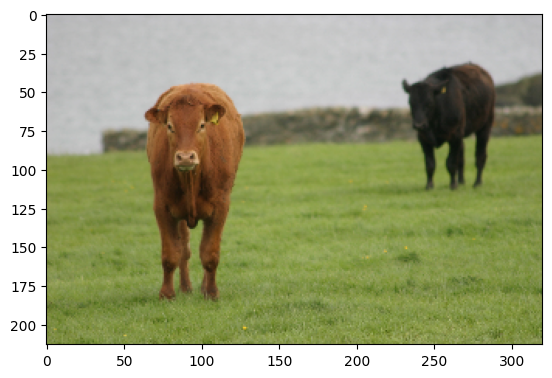

In [2]:
plt.imshow(images[12]["image"])
print(images[12]["name"])

1_21_s.bmp


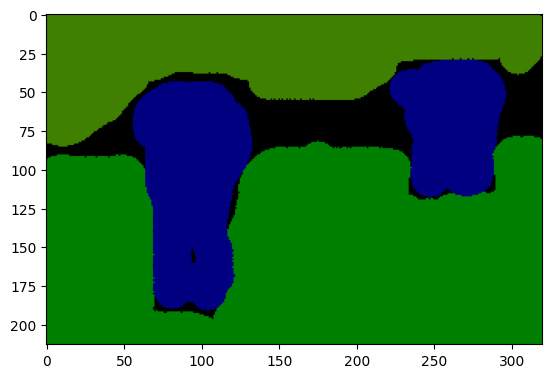

In [3]:
plt.imshow(images[12]["imageGT"])
print(images[12]["name"])

## Step 2: Creating the super-pixel and performing nCut for each image 

In [4]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import data, segmentation, color
from skimage import graph
from matplotlib import pyplot as plt

def sp_nCut(img, compactness= 64, n_segments = 200, sigma = 1):
    
    superPixel_mask = slic(img, compactness=compactness, n_segments = n_segments, sigma = sigma, start_label=1)
    superPixel_img = color.label2rgb(superPixel_mask, img, kind='avg')
    g = graph.rag_mean_color(img, superPixel_mask, mode='similarity')
    
    labels2 = graph.cut_normalized(superPixel_mask, g)
    nCut = color.label2rgb(labels2, img, kind='avg')
    return superPixel_mask, superPixel_img, nCut, labels2

    

for each image we perform create the superPixel and the perfrom the nCut as defined in the function sp_nCut

In [5]:
for img in tqdm(images[:25]):
    img["superPixel_mask"], img["superPixel_img"], img["nCut"], img["nCut_label"] = sp_nCut(img["image"])
     

100%|██████████| 25/25 [00:31<00:00,  1.28s/it]


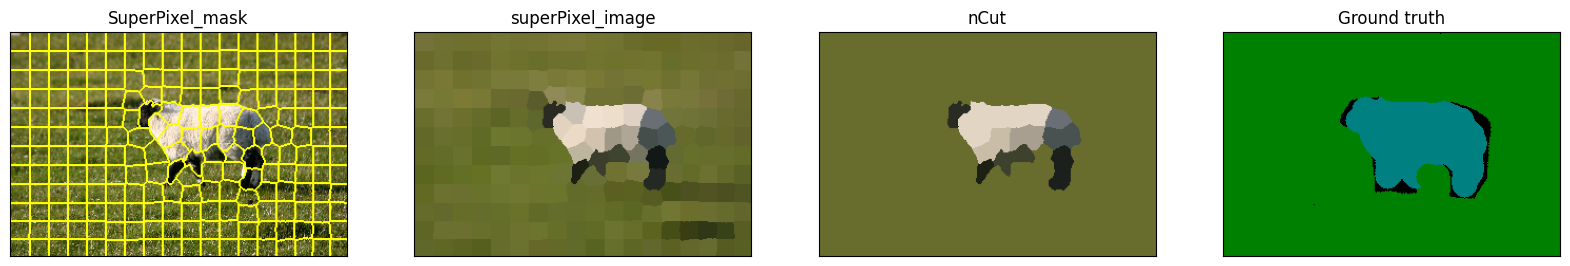

In [6]:
pic_id = 20
fig, ax = plt.subplots(1, 4, figsize=(20, 15))

ax[0].imshow(mark_boundaries(images[pic_id]["image"], images[pic_id]["superPixel_mask"]))
ax[0].set_title("SuperPixel_mask")
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(images[pic_id]["superPixel_img"])
ax[1].set_title("superPixel_image")
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(images[pic_id]["nCut"])
ax[2].set_title("nCut")
ax[2].set_xticks([])
ax[2].set_yticks([])

ax[3].imshow(images[pic_id]["imageGT"])
ax[3].set_title("Ground truth")
ax[3].set_xticks([])
ax[3].set_yticks([])

plt.show()

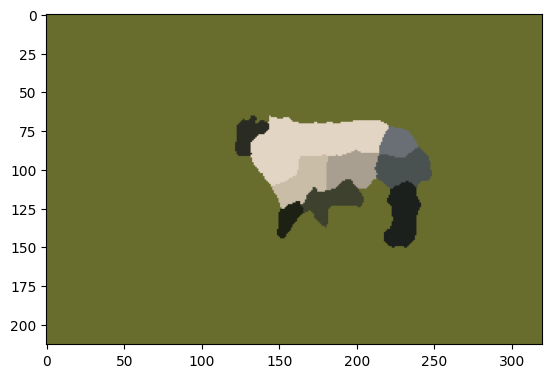

In [7]:
plt.imshow(images[pic_id]["nCut"])

In [8]:
import numpy as np

def closest_color(colors, x):
    closest_distance = float('inf')
    closest_color = None
    for color in colors:
        distance = ((color[0]-x[0])**2 + (color[1]-x[1])**2 + (color[2]-x[2])**2)**0.5
        if distance < closest_distance:
            closest_distance = distance
            closest_color = color
    return closest_color



# get list of regions and their colors of gt image 
def get_list_of_colors(img): 
  arr = np.array(img)  
  reshaped_arr = arr.reshape(-1, 3) 
  unique_colors, counts = np.unique(reshaped_arr, axis=0, return_counts=True) 
  color_counts = dict(zip(map(tuple, unique_colors), counts)) 
  sorted_color_counts = dict(sorted(color_counts.items(), key=lambda item: item[1], reverse=True)) 

  return sorted_color_counts 
 
def smooth_image(image):
    n_labels = len(get_list_of_colors(image["imageGT"]))
    
    h, w, c = image["imageGT"].shape
    color_counts_nc = get_list_of_colors(image["nCut"])
    colors = list(color_counts_nc.keys())[:n_labels]
    
    #print(colors)
    new_pic = image["nCut"]
    for x in range(0,h):
        for y in range(0,w):    
            colour = (new_pic[x,y,0],new_pic[x,y,1],new_pic[x,y,2])
            index = 0     
            
            if colour in color_counts_nc:
                index = list(color_counts_nc).index(colour)           
            
            if index > n_labels:
                new_pic[x,y,:] =  closest_color(colors, colour)
                
    return new_pic

The update color function changes the color of the image in the same color schema of the ground trouth in order to compare our prediction to it

In [9]:
def update_color(image):
    
    color_counts_gt = get_list_of_colors(image["imageGT"]) 
    color_counts_nc = get_list_of_colors(image["nCut"])

    h, w, c = image["nCut"].shape
    new_pic = image["nCut"]

    for x in range(0,h):
        for y in range(0,w):    
            colour = (new_pic[x,y,0],new_pic[x,y,1],new_pic[x,y,2])
            index = 0
                           
            if colour in color_counts_nc:
                index = list(color_counts_nc).index(colour)
        
                        
            if index > len(color_counts_gt)-1:
                new_pic[x,y,:] =  tuple(map(int, list(color_counts_gt)[-1]))
            else: 
                new_pic[x,y,:] =  tuple(map(int, list(color_counts_gt)[index]))
    return new_pic

In [10]:
for image in tqdm(images[:25]):
    smooth_image(image)
    update_color(image)

  4%|▍         | 1/25 [00:00<00:09,  2.54it/s]C:\Users\super\AppData\Local\Temp\ipykernel_6620\3913870073.py:7: RuntimeWarning: overflow encountered in scalar subtract
  distance = ((color[0]-x[0])**2 + (color[1]-x[1])**2 + (color[2]-x[2])**2)**0.5
100%|██████████| 25/25 [00:11<00:00,  2.21it/s]


## Step 3: Accuracy metrics


In [11]:
from skimage import metrics
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import jaccard_score
import numpy as np

# The SSIM values range between 0 to 1 where 1 means a perfect match between the original image and the copy.
def ssim_score(truth, prediction):
    s = ssim(truth.reshape(-1), prediction.reshape(-1))
    return s


def iou_score(truth, prediction):
    jac = jaccard_score(y_true=np.asarray(truth).flatten(),y_pred=np.asarray(prediction).flatten(),average = "macro")
    return jac

I print the accuracy between the ground trouth and the predicted image.
two metrics have been used: the ssim and the jaccard 

In [ ]:
array_avg_ja = [] 
array_avg_ssim = []

for i in tqdm(range(0,8)):
    
    avarage_score_jaccard = 0
    avarage_score_ssim = 0
    hits_per_category = 0
     
    for pic in images:
        img = {}
        index = int(pic["name"][0])
        if(index == i+1):
            img["imageGT"] = pic["imageGT"]
            img["superPixel_mask"], img["superPixel_img"], img["nCut"] , img["nCut_label"] = sp_nCut(pic["image"]) 
      
            img["nCut"] = smooth_image(img)
            img["nCut"] = update_color(img)
            
            avarage_score_jaccard += iou_score(pic["imageGT"], img["nCut"])
            avarage_score_ssim += ssim_score(pic["imageGT"], img["nCut"])
            hits_per_category +=1
        
    array_avg_ja.append(avarage_score_jaccard/hits_per_category)
    array_avg_ssim.append(avarage_score_ssim/hits_per_category)

In [30]:
for i in range (0,8): 
    print("average score for label ", i+1, " jaccardi: ", array_avg_ja[i], " ssim: ", array_avg_ssim[i])

average score for label  1  jaccardi:  0.735001554866219  ssim:  0.6886335105234368
average score for label  2  jaccardi:  0.5613811298551887  ssim:  0.5102467334608883
average score for label  3  jaccardi:  0.5099983776249137  ssim:  0.39433449906756685
average score for label  4  jaccardi:  0.4459100424597221  ssim:  0.5291457259096914
average score for label  5  jaccardi:  0.6111929706721393  ssim:  0.4791111230637006
average score for label  6  jaccardi:  0.36510976674971046  ssim:  0.54604602396202
average score for label  7  jaccardi:  0.40526799141681086  ssim:  0.38662307243401345
average score for label  8  jaccardi:  0.4192958713914252  ssim:  0.43018162292993034


## Step 4: examples of good segmented images

In [31]:
images_example = []

id_pic='1_27'
path = './MSRC_ObjCategImageDatabase_v1/'+str(id_pic)+'_s.bmp'
path_GT = './MSRC_ObjCategImageDatabase_v1/'+str(id_pic)+'_s_GT.bmp'
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_GT = cv2.imread(path_GT)
image_GT = cv2.cvtColor(image_GT, cv2.COLOR_BGR2RGB)
dic = {"name":"1_3_s.bmp", "image":image, "imageGT":image_GT}
images_example.append(dic)

id_pic='1_29'
path = './MSRC_ObjCategImageDatabase_v1/'+str(id_pic)+'_s.bmp'
path_GT = './MSRC_ObjCategImageDatabase_v1/'+str(id_pic)+'_s_GT.bmp'
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_GT = cv2.imread(path_GT)
image_GT = cv2.cvtColor(image_GT, cv2.COLOR_BGR2RGB)
dic = {"name": str(id_pic)+'_s.bmp', "image":image, "imageGT":image_GT}
images_example.append(dic)

for img in tqdm(images_example):
    img["superPixel_mask"], img["superPixel_img"], img["nCut"], img["nCut_label"] = sp_nCut(img["image"], n_segments=200)

100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


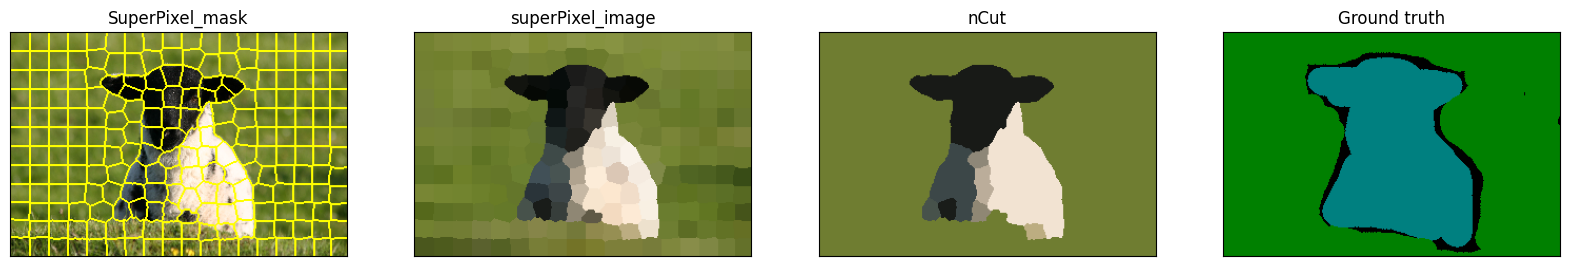

In [32]:
pic_id = 0
fig, ax = plt.subplots(1, 4, figsize=(20, 15))

ax[0].imshow(mark_boundaries(images_example[pic_id]["image"], images_example[pic_id]["superPixel_mask"]))
ax[0].set_title("SuperPixel_mask")
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(images_example[pic_id]["superPixel_img"])
ax[1].set_title("superPixel_image")
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(images_example[pic_id]["nCut"])
ax[2].set_title("nCut")
ax[2].set_xticks([])
ax[2].set_yticks([])

ax[3].imshow(images_example[pic_id]["imageGT"])
ax[3].set_title("Ground truth")
ax[3].set_xticks([])
ax[3].set_yticks([])

plt.show()

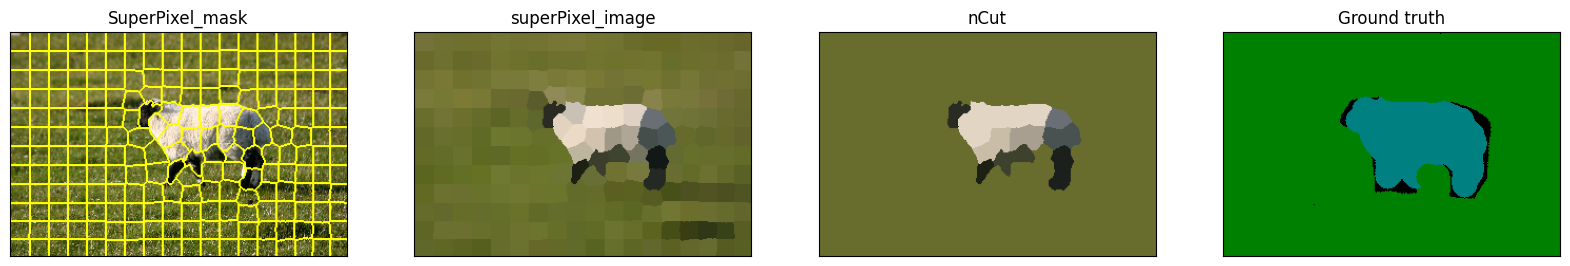

In [33]:
pic_id = 1
fig, ax = plt.subplots(1, 4, figsize=(20, 15))

ax[0].imshow(mark_boundaries(images_example[pic_id]["image"], images_example[pic_id]["superPixel_mask"]))
ax[0].set_title("SuperPixel_mask")
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(images_example[pic_id]["superPixel_img"])
ax[1].set_title("superPixel_image")
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(images_example[pic_id]["nCut"])
ax[2].set_title("nCut")
ax[2].set_xticks([])
ax[2].set_yticks([])

ax[3].imshow(images_example[pic_id]["imageGT"])
ax[3].set_title("Ground truth")
ax[3].set_xticks([])
ax[3].set_yticks([])

plt.show()

In [34]:
for image in tqdm(images_example):
    smooth_image(image)
    update_color(image)

  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\super\AppData\Local\Temp\ipykernel_6620\3913870073.py:7: RuntimeWarning: overflow encountered in scalar subtract
  distance = ((color[0]-x[0])**2 + (color[1]-x[1])**2 + (color[2]-x[2])**2)**0.5
100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


In [35]:
for pic_id in range (0, len(images_example)):
    print(images_example[pic_id]["name"])
    print(iou_score(images_example[pic_id]["imageGT"], images_example[pic_id]["nCut"]))
    print(ssim_score(images_example[pic_id]["imageGT"], images_example[pic_id]["nCut"]))

1_3_s.bmp
0.7871599489564758
0.8022747145720875
1_29_s.bmp
0.9206854170606933
0.9293928831435841
